In [1]:
# environment: thesisPlayground_pointClouds_env

In [2]:
import h5py
import numpy as np
import open3d as o3d
import pandas as pd
import glob
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Using depths
### No indications on the color

Hints on how to deal with this problem from:
- https://github.com/apple/ml-hypersim/issues/9 (source for the code for the conversion Euclidean distance in meters to the optical center of the camera -> distances wrt the plane of the camera)
- https://github.com/apple/ml-hypersim/issues/10 (found where to get the conversion asset units <-> meters)

In [15]:
base_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes'
scene = 'ai_007_008'  # name of the scene, with format ai_VVV_NNN
cam_xx = 'cam_00'

path_metadata_camera_parameters = '/local/home/gmarsich/Desktop/Thesis/0Code_playground/pointClouds/pointClouds_ChatGPT/withDepths/metadata_camera_parameters.csv'
path_metadata_scene = os.path.join(base_path, scene, '_detail', 'metadata_scene.csv')
path_orientations = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_orientations.hdf5')
path_positions = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_positions.hdf5')

In [16]:
def get_depths_oneImage(path_file, path_metadata_scene, intWidth = 1024, intHeight = 768, fltFocal = 886.81): # TODO: understand fltFocal

    '''
    Processes a dataset containing depth information of an image, and transforms the depth values to be relative to the plane of a camera.
    This function reads the depth data from an HDF5 file, whose path is given, gets the depth values for each pixel, and applies a transformation
    to obtain the depth values relative to the camera plane.

    Parameters:
    - file_path (str): The path to the HDF5 file containing the dataset with depth information, in meters.
    - path_metadata_scene (str): The path to the csv file to get the conversion meters <-> asset units
    - intWidth (int, optional): The width of the image in pixels. Default is 1024.
    - intHeight (int, optional): The height of the image in pixels. Default is 768.
    - fltFocal (float, optional): The focal length of the camera. Default is 886.81.

    Returns:
    - npyDepths (numpy.ndarray): A 2D numpy array of shape (intHeight, intWidth) containing the depth values for each pixel in the image,
        relative to the camera plane. Measures in asset coordinates
    '''

    data_frame = pd.read_csv(path_metadata_scene)
    meters_per_asset_unit = data_frame.loc[data_frame['parameter_name'] == 'meters_per_asset_unit', 'parameter_value'].values[0]


    with h5py.File(path_file, 'r') as file:
        # Access the dataset and read the data
        dataset = file['dataset']
        data = dataset[:]
        
        # Define the list of 2D points (row, column) to get the depth values for
        points = [(y, x) for y in range(intHeight) for x in range(intWidth)]
        
        # Get the depth values for the specified points
        npyDistances_array = [data[y, x] for y, x in points]
        
        # Apply transformation (Euclidean distance in meters to the optical center of the camera -> distances wrt the plane of the camera)
        npyImageplaneX = np.linspace((-0.5 * intWidth) + 0.5, (0.5 * intWidth) - 0.5, intWidth).reshape(1, intWidth).repeat(intHeight, 0).astype(np.float32)[:, :, None]
        npyImageplaneY = np.linspace((-0.5 * intHeight) + 0.5, (0.5 * intHeight) - 0.5, intHeight).reshape(intHeight, 1).repeat(intWidth, 1).astype(np.float32)[:, :, None]
        npyImageplaneZ = np.full([intHeight, intWidth, 1], fltFocal, np.float32)
        npyImageplane = np.concatenate([npyImageplaneX, npyImageplaneY, npyImageplaneZ], 2)

        npyDistances = np.array(npyDistances_array)
        npyDistances = npyDistances.reshape(768, 1024)

        npyDepths_meters = npyDistances / np.linalg.norm(npyImageplane, 2, 2) * fltFocal

        # Conversion meters -> asset units
        npyDepths_assetCoo = npyDepths_meters / meters_per_asset_unit

        return npyDepths_assetCoo


def get_depths(path_list, path_metadata_scene):
    '''
    Processes a list of paths to HDF5 files containing depth information.
    It iterates through each file path, applies the `get_depths_oneImage` function to obtain the depth values
    relative to the camera plane for each image, and collects these depth representations into a list.

    Parameters:
    - path_list (list of str): A list of file paths to HDF5 files containing depth information.
    - path_metadata_scene (str): The path to the csv file to get the conversion meters <-> asset units.

    Returns:
    - depth_files (list): A list containing representations of depth information for each image in `path_list`, and each element represents an image.
        Measures in asset units
    '''
    
    depth_files = []
    for i in range(len(path_list)):
        depth_files.append(get_depths_oneImage(path_list[i], path_metadata_scene))

    return depth_files

In [18]:
# Get list of depth HDF5 files
depthEuclidean_paths = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_geometry_hdf5', '*.depth_meters.hdf5')))

# Get depth information for each image
depth_files = get_depths(depthEuclidean_paths, path_metadata_scene)

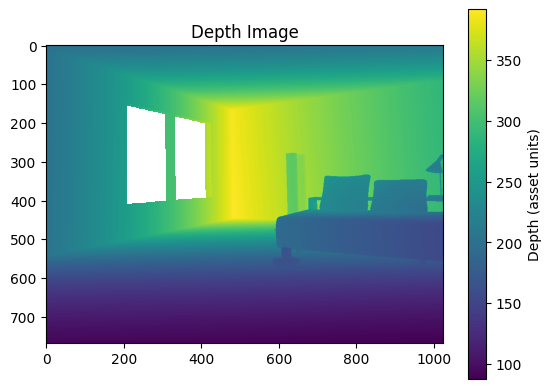

In [19]:
# TEST on one image
import matplotlib.pyplot as plt

plt.imshow(depth_files[2], cmap='viridis')  # Choose a colormap suitable for depth visualization
plt.colorbar(label='Depth (asset units)')  # Add a colorbar to show depth values
plt.title('Depth Image')  # Add a title to the plot
plt.show()

In [47]:
def get_intrinsics_with_tiltShift(path_metadata, scene_name):
    """
    This function calculates the intrinsic matrix for a camera considering given tilt and shift effects, using metadata from a CSV file.

    Parameters:
        path_metadata (str): Path to the metadata CSV file containing camera settings.
        scene_name (str): Name of the scene for which the intrinsic matrix is computed.

    Returns:
        intrinsic_matrix (numpy.ndarray): 3x3 array representing the camera intrinsic matrix. 
    """

    # Load the metadata CSV file
    df = pd.read_csv(path_metadata)
    
    # Filter the DataFrame to get the row corresponding to the specified scene
    scene_row = df[df['scene_name'] == scene_name]
    
    if scene_row.empty:
        raise ValueError(f"Scene '{scene_name}' not found in the metadata.")
    
    # Use the first matching row
    scene_row = scene_row.iloc[0]

    # Extract the necessary parameters from the metadata
    img_width = scene_row["settings_output_img_width"]
    img_height = scene_row["settings_output_img_height"]
    focal_length = scene_row["camera_physical_focal_length"]
    sensor_width = scene_row["camera_physical_film_width"]

    # Calculate fx and fy using the focal length and sensor width
    fx = focal_length / sensor_width * img_width
    fy = fx  # Assuming square pixels

    # Calculate the principal point (cx, cy) considering horizontal and vertical shifts
    cx = img_width / 2 + scene_row["camera_physical_horizontal_shift"]
    cy = img_height / 2 + scene_row["camera_physical_lens_shift"]

    # Construct the intrinsic matrix
    intrinsic_matrix = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    print(intrinsic_matrix)

    return intrinsic_matrix


In [50]:
# TEST
def depth_to_point_cloud(depth_image, intrinsic_matrix):
    """
    Convert a depth image to a point cloud.

    Parameters:
        depth_image (numpy.ndarray): 2D array where each cell contains the depth value for the associated point in the image.
        intrinsic_matrix (numpy.ndarray): 3x3 camera intrinsic matrix.

    Returns:
        point_cloud (numpy.ndarray): Nx3 array of 3D points in the camera coordinate system.
    """
    
    # Get the dimensions of the depth image
    height, width = depth_image.shape

    # Create a grid of (u, v) coordinates corresponding to the pixels
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the u, v, and depth arrays
    u = u.flatten()
    v = v.flatten()
    depth = depth_image.flatten()

    # Intrinsic matrix parameters
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]

    # Convert depth image to 3D point cloud
    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth

    # Stack x, y, z to get a Nx3 point cloud
    point_cloud = np.stack((x, y, z), axis=-1)

    return point_cloud

def rendering(point_cloud):
    """
    Render a point cloud using open3d.

    Parameters:
        point_cloud (numpy.ndarray): Nx3 array of 3D points in the camera coordinate system.
    """
    # Create an open3d PointCloud object
    pcd = o3d.geometry.PointCloud()

    # Assign points to the PointCloud object
    pcd.points = o3d.utility.Vector3dVector(point_cloud)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

intrinsic_matrix = get_intrinsics_with_tiltShift(path_metadata_camera_parameters, scene)
point_cloud = depth_to_point_cloud(depth_files[2], intrinsic_matrix)

rendering(point_cloud)

[[1.43810735e+03 0.00000000e+00 5.12000000e+02]
 [0.00000000e+00 1.43810735e+03 3.83920000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [53]:
def extract_frame_ids(paths_filenames):
    """
    Extracts frame IDs from a list of filenames.
    
    Parameters:
        paths_filenames (list): List of file paths. Last info of a path is the filename.
    
    Returns:
        list: List of extracted frame IDs.
    """

    frame_ids = []
    for path_filename in paths_filenames:
        filename = path_filename.split('/')[-1]  # Extracting just the filename from the path
        frame_id_str = filename.split('.')[1]
        frame_id = int(frame_id_str)
        frame_ids.append(frame_id)

    return frame_ids


def get_extrinsics_oneImage(path_positions, path_orientations, frame_id):
    """
    Load camera position and orientation from a HDF5 file and compute the extrinsic matrix for that frame.

    Parameters:
        path_positions (str): Path to the camera positions HDF5 file. The file contains the data in asset units, not in meters
        path_orientations (str): Path to the camera orientations HDF5 file. See https://github.com/apple/ml-hypersim/tree/main?tab=readme-ov-file#camera-trajectories
            for more information
        frame_id (int): Frame ID to extract the extrinsics for.

    Returns:
        np.ndarray: The extrinsic matrix [R|t], that is 3x4.
    """

    # Load camera position
    with h5py.File(path_positions, "r") as f:
        camera_positions = f["dataset"][:]
    
    # Load camera orientation
    with h5py.File(path_orientations, "r") as f:
        camera_orientations = f["dataset"][:]
    
    # Get position and rotation matrix for the specified frame
    camera_position_world = camera_positions[frame_id]
    R_world_from_cam = camera_orientations[frame_id]

    # Construct the extrinsic matrix [R|t]
    extrinsic_matrix = np.hstack((R_world_from_cam, camera_position_world.reshape(3, 1)))
    
    return extrinsic_matrix


def get_extrinsics(path_positions, path_orientations, frames_ids):
    """
    Load camera position and orientation from HDF5 files and compute the extrinsic matrix for each frame.

    Parameters:
        path_positions (str): Path to the camera positions HDF5 file. The file contains the data in asset units, not in meters
        path_orientations (str): Path to the camera orientations HDF5 file. See https://github.com/apple/ml-hypersim/tree/main?tab=readme-ov-file#camera-trajectories
            for more information
        frames_id (list of int): Frames ID to extract the extrinsics for.

    Returns:
        extrinsics (list of numpy.ndarray): A list containing the extrinsic matrix [R|t] for each frame specified in `frames_id`.
            Each extrinsic matrix is a 3x4 transformation matrix representing the camera's position and orientation in the world coordinate system.
    """
    
    extrinsics = []
    for i in range(len(frames_ids)):
        extrinsics.append(get_extrinsics_oneImage(path_positions, path_orientations, frames_ids[i]))

    return extrinsics



def generate_point_clouds(depth_images, intrinsic_matrix, extrinsic_matrices):
    """
    Generates point clouds from a list of depth images using the camera's intrinsic and extrinsic matrices.

    Parameters:
        depth_images (list of numpy.ndarray): A list of 2D numpy arrays representing the depth values for each pixel in each image.
        intrinsic_matrix (numpy.ndarray): 3x3 array representing the camera intrinsic matrix.
        extrinsic_matrices (list of numpy.ndarray): A list of 3x4 arrays representing the camera extrinsic matrices for each image.

    Returns:
        list of numpy.ndarray: A list containing numpy arrays containing the 3D coordinates of the point clouds for each image.
    """

    # Initialize an empty list to store point clouds
    point_clouds = []

    # Loop through each depth image and its corresponding extrinsic matrix
    for depth_image, extrinsic_matrix in zip(depth_images, extrinsic_matrices):
        print("Doing one image out of", len(depth_images))

        # Get image width and height
        height, width = depth_image.shape
        
        # Initialize an empty array to store 3D coordinates
        point_cloud = []
        
        # Loop through each pixel in the depth image
        for y in range(height):
            for x in range(width):
                # Get the depth value for the current pixel
                depth = depth_image[y, x]
                
                # Skip if depth is invalid (e.g., zero)
                if depth == 0:
                    continue
                
                # Calculate the 3D coordinates using the depth value, intrinsic matrix, and extrinsic matrix
                homogeneous_pixel = np.array([x, y, 1])
                camera_coordinates = np.linalg.inv(intrinsic_matrix) @ homogeneous_pixel * depth
                world_coordinates = extrinsic_matrix @ np.append(camera_coordinates, 1)
                
                # Append the 3D coordinates to the point cloud
                point_cloud.append(world_coordinates)
        
        # Convert the list of coordinates to a numpy array and append to the list of point clouds
        point_cloud = np.array(point_cloud)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_cloud)

        point_clouds.append(pcd)
        
    return point_clouds


In [56]:
def render_point_cloud(point_cloud):
    """
    Renders a 3D point cloud using Open3D.

    Parameters:
        point_cloud (o3d.geometry.PointCloud): An Open3D PointCloud object.
    """

    # Create a visualization window
    vis = o3d.visualization.Visualizer()

    # Add the point cloud to the visualization window
    vis.create_window()
    vis.add_geometry(point_cloud)

    # Set the render options (optional)
    render_options = vis.get_render_option()
    render_options.point_size = 2  # Adjust the size of the points

    # Render the visualization
    vis.run()

    # Close the visualization window
    vis.destroy_window()


In [54]:
# TEST
frames_ids = extract_frame_ids(depthEuclidean_paths)

extrinsics = get_extrinsics(path_positions, path_orientations, frames_ids)

point_clouds = generate_point_clouds(depth_files, intrinsic_matrix, extrinsics)

Doing one image out of 3
Doing one image out of 3
Doing one image out of 3


In [59]:
render_point_cloud(point_clouds[2])

In [7]:




def merge_point_clouds(point_clouds):
    """
    Merges multiple Open3D PointCloud objects into a single PointCloud object.

    Parameters:
        point_clouds (list of o3d.geometry.PointCloud): A list of Open3D PointCloud objects.

    Returns:
        o3d.geometry.PointCloud: A single Open3D PointCloud object containing the merged 3D coordinates of all point clouds.
    """
    # Create an empty Open3D PointCloud object to store the merged point cloud
    merged_point_cloud = o3d.geometry.PointCloud()
    
    # Concatenate all the individual point clouds into a single point cloud
    for pcd in point_clouds:
        merged_point_cloud += pcd
    
    return merged_point_cloud




In [8]:

# Get list of depth HDF5 files
depthEuclidean_paths = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_geometry_hdf5', '*.depth_meters.hdf5')))

# Get depth information for each image
depth_files = get_depths(depthEuclidean_paths, path_metadata_scene)

# Get extrinsics matrices, one matrix per image
frames_ids = extract_frame_ids(depthEuclidean_paths)

extrinsics = get_extrinsics(path_positions, path_orientations, frames_ids)
print("Extrinsics Matrix for the first image of the scene:")
print(extrinsics[0])

# Get the intrinsic matrix for the scene
intrinsics = get_intrinsics_with_tiltShift(path_metadata_camera_parameters, scene)
print("Intrinsic Matrix for the scene:")
print(intrinsics)


Extrinsics Matrix for the first image of the scene:
[[ 9.99448895e-01  2.52561085e-03 -3.30993086e-02  7.81024837e+00]
 [-3.31955254e-02  7.60409459e-02 -9.96551991e-01 -2.44333206e+02]
 [ 0.00000000e+00  9.97101486e-01  7.60828778e-02  4.44449768e+01]]
Intrinsic Matrix for the scene:
[[1.43810735e+03 0.00000000e+00 5.12000000e+02]
 [0.00000000e+00 1.43810735e+03 3.83920000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [9]:
# Generate the point clouds
point_clouds = generate_point_clouds(depth_files, intrinsics, extrinsics)


Doing one image out of  3
Doing one image out of  3
Doing one image out of  3


In [10]:
merged_point_cloud = merge_point_clouds(point_clouds)
render_point_cloud(merged_point_cloud)